In [306]:
import datetime
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
from nsepy import get_history
import matplotlib.pyplot as plt
import ta
from ta.momentum import RSIIndicator 
from ta.trend import EMAIndicator
from ta.volatility import BollingerBands
%matplotlib inline

In [307]:
stock_name = input('Enter NSE Stock Name: ').upper()
date_entry = input('Enter a date in yyyy,m,d format')
year, month, day = map(int, date_entry.split(','))
start_date= datetime.date(year, month, day)
end_date = date.today()

# get_history(symbol = 'SBIN', start=date(2015,1,1), end=date(2022,3,1))
def stock_df(s, sd, ed):
    df = get_history(symbol=s, start=sd, end=ed)
    return df

df = stock_df(stock_name, start_date, end_date)
df.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2019-05-02,SBIN,EQ,309.95,308.05,311.4,305.65,307.90,308.15,308.36,16640100,5.131073e+14,115380,3938300,0.2367
2019-05-03,SBIN,EQ,308.15,309.00,311.8,308.80,309.70,310.00,310.33,12452689,3.864468e+14,128941,3818789,0.3067
2019-05-06,SBIN,EQ,310.00,306.80,310.3,305.90,308.60,308.75,308.38,10639216,3.280894e+14,75642,2793193,0.2625
2019-05-07,SBIN,EQ,308.75,310.70,313.4,303.75,305.20,305.45,310.07,15219845,4.719207e+14,112752,4406362,0.2895
2019-05-08,SBIN,EQ,305.45,303.95,305.3,296.75,298.45,298.25,301.51,22103678,6.664560e+14,125035,7179988,0.3248


In [308]:
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
print(df.head())
print(df.shape)

              Open   High     Low   Close    Volume
Date                                               
2019-05-02  308.05  311.4  305.65  308.15  16640100
2019-05-03  309.00  311.8  308.80  310.00  12452689
2019-05-06  306.80  310.3  305.90  308.75  10639216
2019-05-07  310.70  313.4  303.75  305.45  15219845
2019-05-08  303.95  305.3  296.75  298.25  22103678
(778, 5)


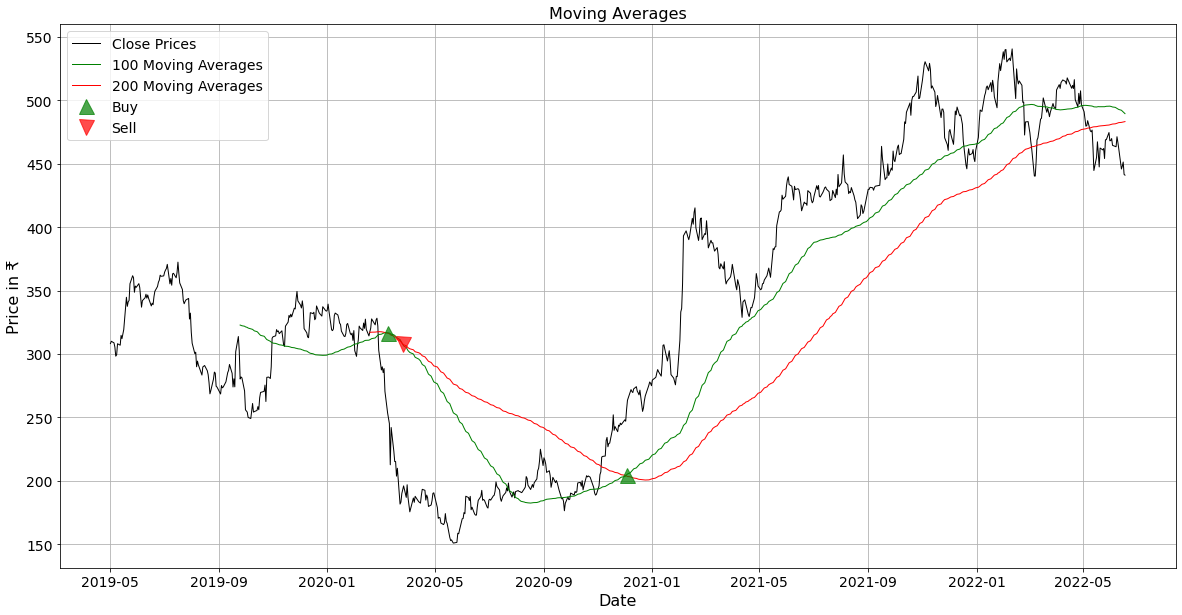

In [309]:
# Indicator 1 - Momentum
# Moving Averages
def moving_average(df, short_window = 100, long_window = 200):
    df['MA100'] = df['Close'].rolling(short_window).mean()
    df['MA200'] = df['Close'].rolling(long_window).mean()
    df['MA20'] = df['Close'].rolling(20).mean()
    df['Signal'] = 0
    df['Signal'] = np.where(df['MA100'] > df['MA200'], 1, 0)
    df['Position'] = df['Signal'].diff()

    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df['Close'].plot(color = 'k', lw = 1, label = 'Close Prices')  
    df['MA100'].plot(color = 'g', lw = 1, label = '100 Moving Averages')
    df['MA200'].plot(color = 'r', lw = 1, label = '200 Moving Averages') 

    # plot 'buy' signals
    plt.plot(df[df['Position'] == 1].index, 
            df['MA100'][df['Position'] == 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'Buy')

    # plot 'sell' signals
    plt.plot(df[df['Position'] == -1].index, 
            df['MA100'][df['Position'] == -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'Sell')
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title('Moving Averages', fontsize = 16 )
    plt.legend(fontsize = 14 )
    plt.grid()
    plt.show()

moving_average(df)

In [310]:
# Indicator 2 - Momentum
# Relative Strength Index
rsi = RSIIndicator(df['Close'], 14).rsi()
def relative_strength_index(df, rsi):
    if(rsi[-7:].mean() > 80):
        print('Alert : Do Not buy this stock, market value exceeded 80%')
    if(rsi[-7:].mean() < 20):
        print('Alert : Do Not sell this stock, market value below 20%')
    else:
        if(rsi[-7:].mean() > 50):
            return 'Prefer Buy'
        elif(rsi[-7:].mean() < 50):
            return 'Prefer Sell'
        else:
            return 'Prefer Hold'
    
relative_strength_index(df, rsi)

'Prefer Sell'

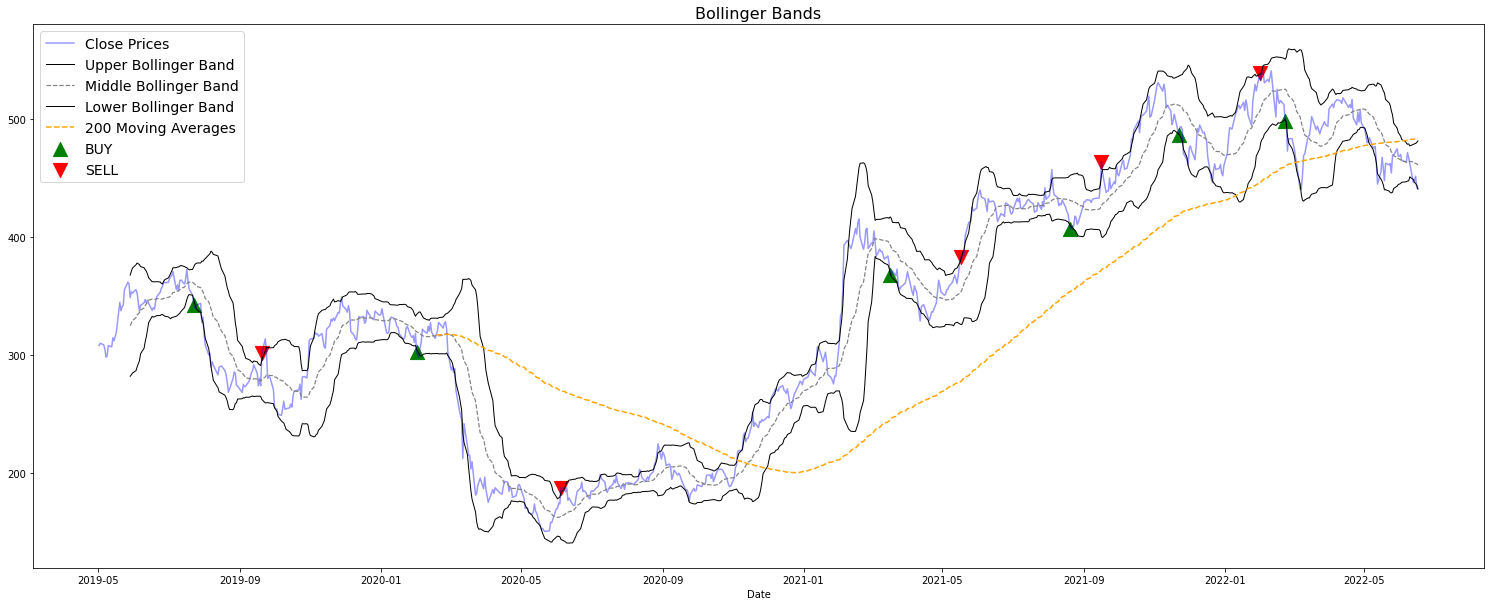

In [311]:
# Indicator - 3 Volatility
# Bollinger Bands
def bb(data, sma, window = 20):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb

df['upper_bb'], df['lower_bb'] = bb(df['Close'], df['MA20'])

def bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

buy_price, sell_price, bb_signal = bb_strategy(df['Close'], df['lower_bb'], df['upper_bb'])
plt.figure(figsize=(26,10))
df['Close'].plot(label = 'Close Prices', alpha = 0.4, color = 'blue')
df['upper_bb'].plot(label = 'Upper Bollinger Band', linewidth = 1, color = 'black')
df['MA20'].plot(label = 'Middle Bollinger Band', linestyle = '--', linewidth = 1.2, color = 'grey')
df['lower_bb'].plot(label = 'Lower Bollinger Band', linewidth = 1, color = 'black')
df['MA200'].plot(label = '200 Moving Averages', linestyle = '--', linewidth = 1.5, color = 'orange')
plt.scatter(df.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(df.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('Bollinger Bands', fontsize = 16)
plt.legend(loc = 'upper left', fontsize = 14)
plt.show()

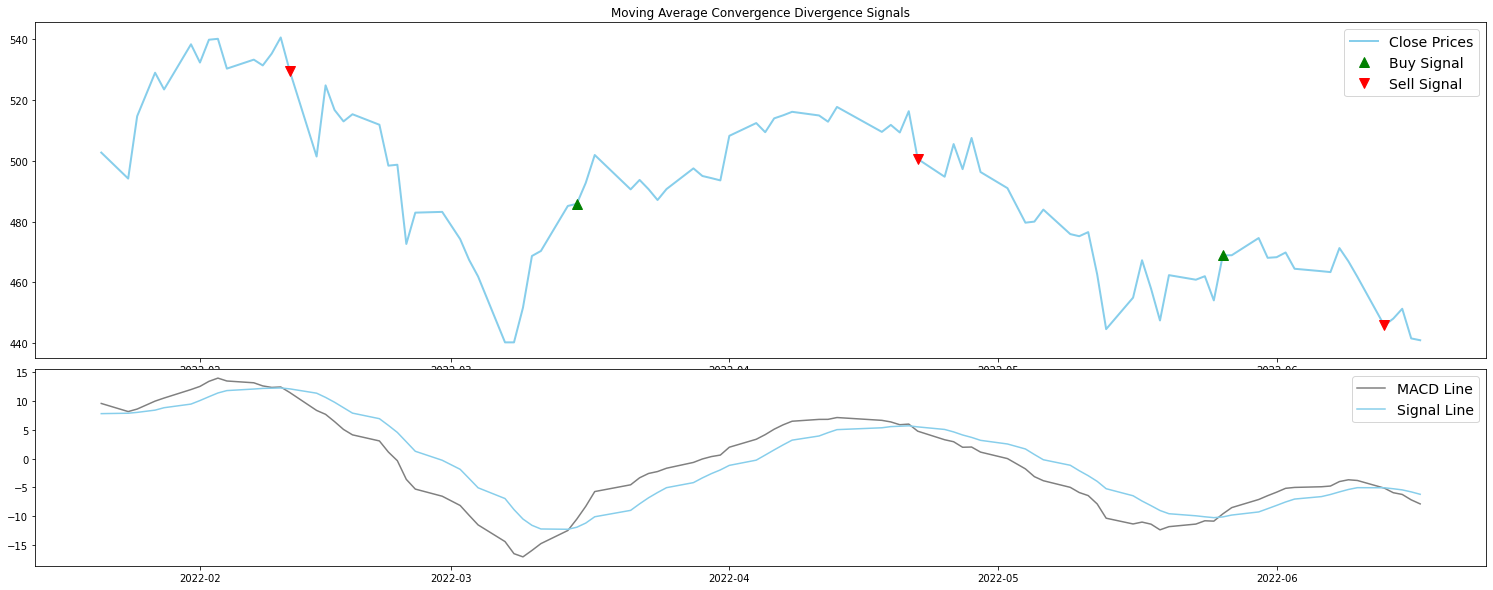

In [312]:
def get_macd(price, slow = 26, fast = 12, smooth = 9):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df


df_macd = get_macd(df['Close'])

def macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal
            
buy_price, sell_price, macd_signal = macd_strategy(df['Close'], df_macd)

plt.figure(figsize=(26,10))
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['Close'][-100:], color = 'skyblue', linewidth = 2, label = 'Close Prices')
ax1.plot(df.index[-100:], buy_price[-100:], marker = '^', color = 'green', markersize = 10, label = 'Buy Signal', linewidth = 0)
ax1.plot(df.index[-100:], sell_price[-100:], marker = 'v', color = 'r', markersize = 10, label = 'Sell Signal', linewidth = 0)
ax1.legend(fontsize = 14)
ax1.set_title('Moving Average Convergence Divergence Signals')
ax2.plot(df_macd['macd'][-100:], color = 'grey', linewidth = 1.5, label = 'MACD Line')
ax2.plot(df_macd['signal'][-100:], color = 'skyblue', linewidth = 1.5, label = 'Signal Line')
plt.legend(loc = 'upper right', fontsize = 14)
plt.show()

# for i in range(len(df_macd[-100:])):
    
#     if str(df_macd['hist'][:len(df_macd)-i])[0] == '-':
#         ax2.bar(df_macd.index[len(df_macd)-i], df_macd['hist'][len(df_macd)-i], color = 'green')
#     else:
#         ax2.bar(df_macd.index[len(df_macd)-i], df_macd['hist'][len(df_macd)-i], color = 'red')
        


In [313]:
ema = EMAIndicator(df['Close'], 200)
df['EMA'] = ema.ema_indicator()
def addemasignal(df, backcandles):
    emasignal = [0]*len(df)
    for row in range(backcandles, len(df)):
        upt = 1
        dnt = 1
        for i in range(row-backcandles, row+1):

            if df.High[i]>=df.EMA[i]:
                dnt=0
            if df.Low[i]<=df.EMA[i]:
                upt=0

        if upt==1 and dnt==1:
            emasignal[row]=3
        elif upt==1:
            emasignal[row]=2
        elif dnt==1:
            emasignal[row]=1
    df['EMASignal'] = emasignal

addemasignal(df,6)


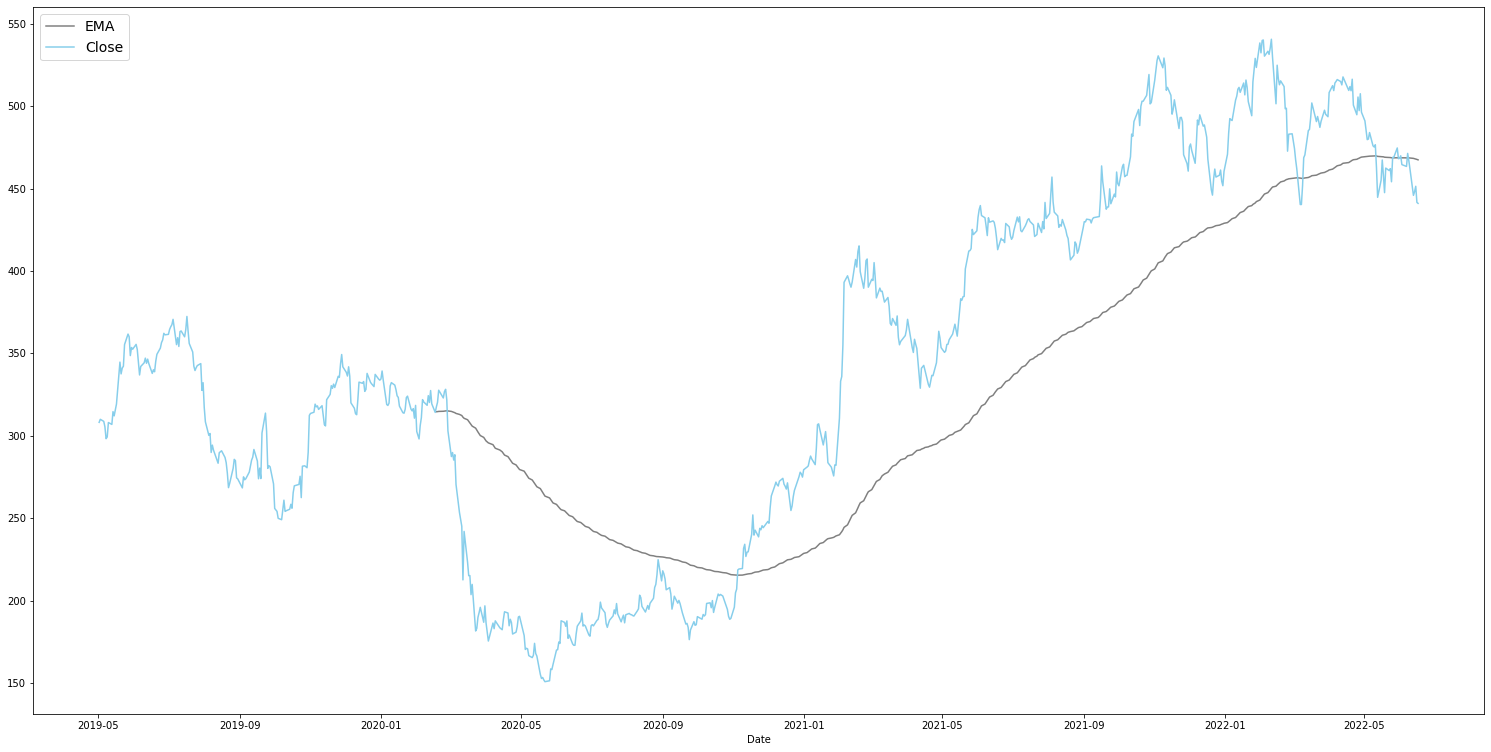

In [332]:
df.EMA.plot(color = 'grey', linewidth = 1.5, label = 'EMA', figsize = (26,13))
df.Close.plot(color = 'skyblue', linewidth = 1.5, label = 'Close')
plt.legend(loc = 'upper left', fontsize = 14)

In [316]:
df.EMASignal.value_counts()

2    357
3    193
1    158
0     70
Name: EMASignal, dtype: int64